### *A* | *B* Testing Using MCMC and PyMC3

Probably not a good choice for now. Development for Theano, PyMC3's backend, came to end this past October. PyMC devs are exploring other backends (PyTorch, MXNet, TensorFlow/probability), but so far there is only one script testing a backend (PyTorch) in the the PyMC4 prototype repo.

https://github.com/pymc-devs/pymc3/issues/1650

Stan (via PyStan or RStan) or the greta R package (with TensorFlow backend) may be better long-run probablistic programming / Bayesian modeling toolkits. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize


import pymc3 as pm
import numpy as np
import scipy.stats as stats
from scipy.optimize import fmin_powell;

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [3]:
# Set (unobserved) true population means for control and treatment
true_pA = 0.05
true_pB = 0.055

# Number of observations for each group
nA = 20000
nB = 20000

# Generate observations
observations_A = stats.bernoulli.rvs(true_pA, size=nA)
observations_B = stats.bernoulli.rvs(true_pB, size=nB)

In [4]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.05185
0.0565


In [5]:
# Assume Uniform priors for pA and pB

with pm.Model() as model:
    # Set starting values to means of generated observations for A and B
    pA = pm.Uniform("pA", 0, 1, testval = observations_A.mean())
    pB = pm.Uniform("pB", 0, 1, testval = observations_B.mean())
    
    # Define the deterministic delta function, the unknown of interest
    delta = pm.Deterministic("delta", pB - pA)

    # Set of observations for A and B
    obs_A = pm.Bernoulli("obs_A", pA, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", pB, observed=observations_B)

    # Use Powell's Method from scipy.optimize for MAP estimation
    start = pm.find_MAP(fmin=fmin_powell)
    step = pm.Metropolis()
    trace = pm.sample(60000, step=step, start=start)


/usr/local/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -8,423.1:   1%|          | 40/5000 [00:00<00:02, 2041.87it/s]

Optimization terminated successfully.
         Current function value: 8423.067103
         Iterations: 1
         Function evaluations: 49


logp = -8,423.1:   1%|          | 49/5000 [00:01<01:56, 42.50it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pB_interval__]
>Metropolis: [pA_interval__]
100%|██████████| 60500/60500 [00:48<00:00, 1246.67it/s]
The number of effective samples is smaller than 25% for some parameters.


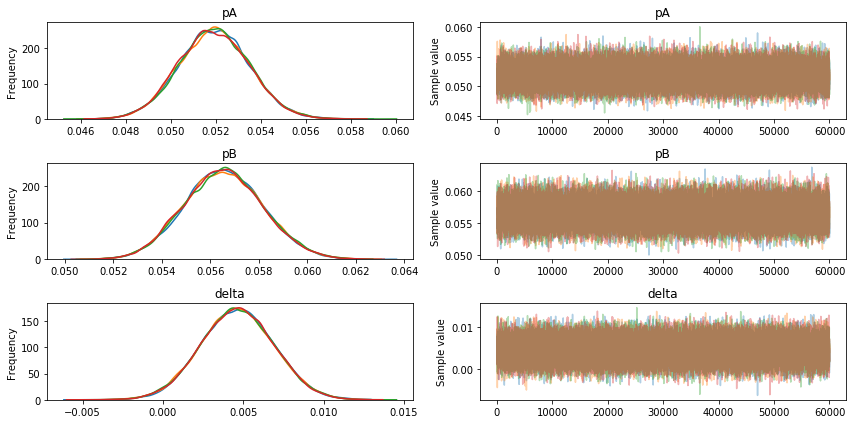

In [6]:
# Examine sample raw convergence
pm.plots.traceplot(trace);

In [7]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pA,0.051908,0.001565,0.000007,0.048825,0.054958,48498.0,1.000004
pB,0.056539,0.001634,0.000006,0.053374,0.059750,45642.0,1.000016
delta,0.004631,0.002268,0.000009,0.000164,0.009018,48696.0,0.999996


In [8]:
# You can vary burn in and trim to post hoc to aid convergence (Rhat)

# Toss burn in samples (~10% generally optimal for generated data, depending on run)
burned_trace=trace[4000:]
# Additionally we can trim the samples to adjust for autocorrelation
burned_trace=trace[::2]

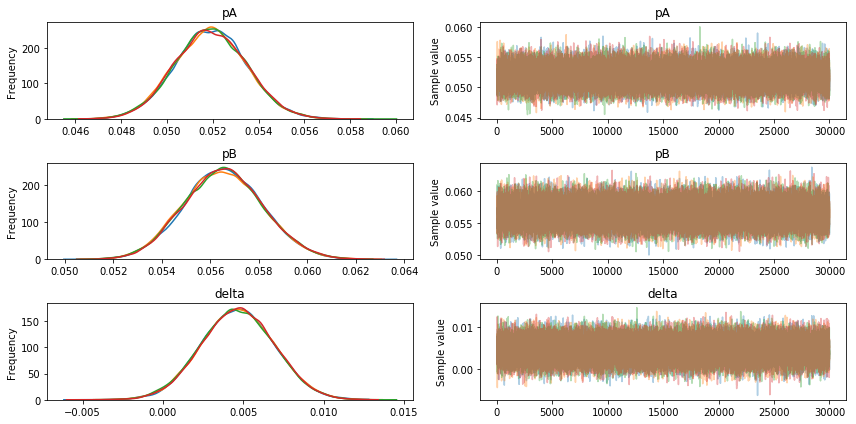

In [9]:
# Examine sample convergence after discarding burn in samples
pm.plots.traceplot(burned_trace);

In [10]:
pm.stats.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pA,0.051908,0.001565,0.000007,0.048825,0.054959,46600.0,0.999998
pB,0.056538,0.001633,0.000007,0.053374,0.059750,43902.0,1.000007
delta,0.004630,0.002268,0.000010,0.000174,0.009017,46580.0,0.999989


In [11]:
pA_samples = burned_trace["pA"]
pB_samples = burned_trace["pB"]
delta_samples = burned_trace["delta"]

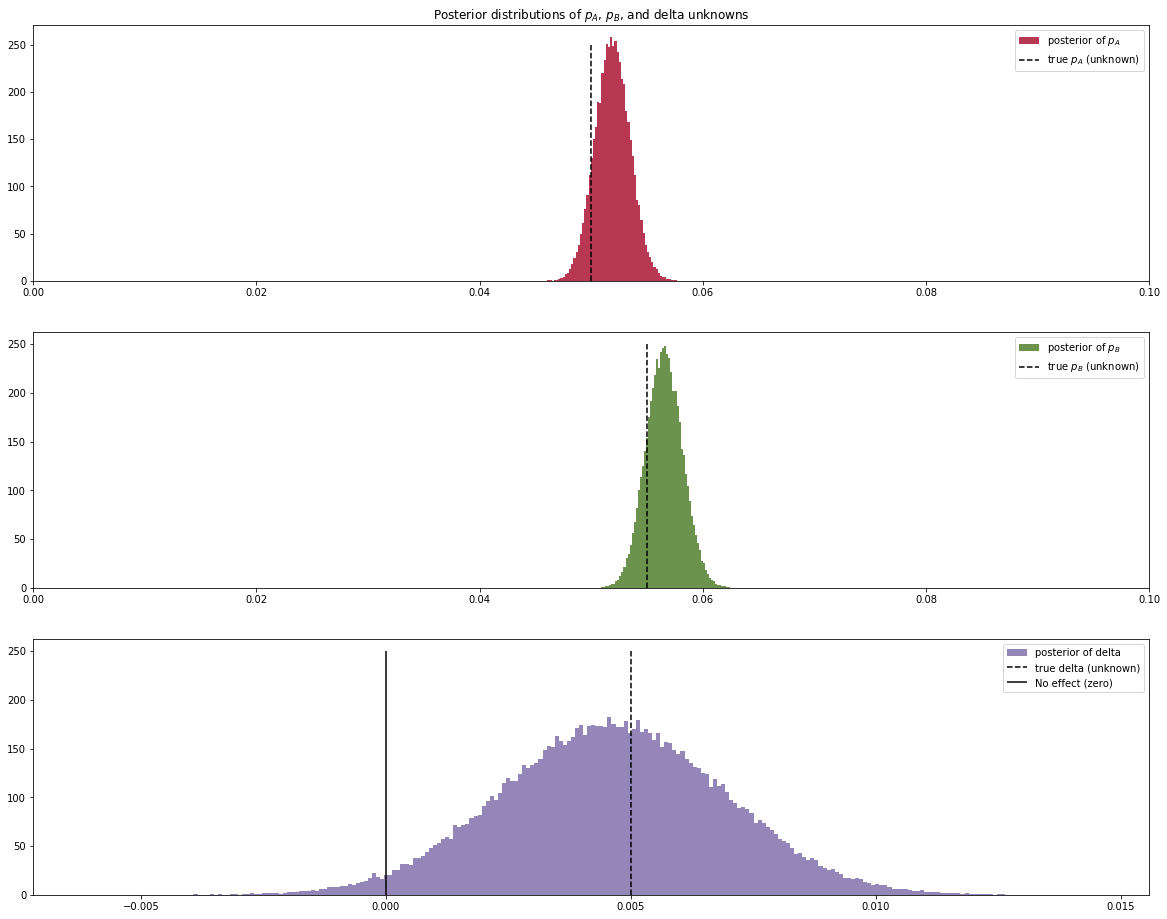

In [12]:
# Histogram of posteriors
figsize(20, 16)

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(pA_samples, histtype='stepfilled', bins=75, alpha=0.80,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_pA, 0, 250, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(pB_samples, histtype='stepfilled', bins=75, alpha=0.80,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_pB, 0, 250, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)

plt.hist(delta_samples, histtype='stepfilled', bins=250, alpha=0.80,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_pB - true_pA, 0, 250, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 250, color="black", alpha=1, label="No effect (zero)")
plt.legend(loc="upper right");

In [13]:
# Probability that treatment B is better than control A

print("Probability treatment B is WORSE than control A: %.3f" % \
    np.mean(delta_samples < 0))
print("Probability treatment B is BETTER than control A: %.3f" % \
    np.mean(delta_samples > 0))

Probability treatment B is WORSE than control A: 0.020
Probability treatment B is BETTER than control A: 0.980


In [14]:
# Credible Interval, alpha = .05
pm.stats.hpd(delta_samples, alpha=0.05)

array([0.00017378, 0.00901675])

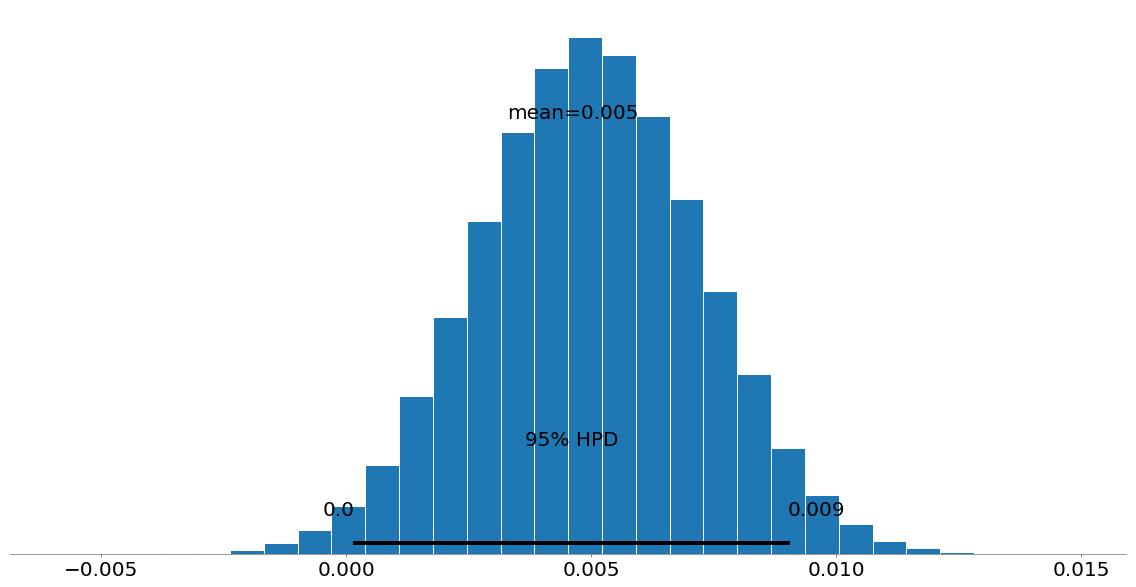

In [15]:
# Historgram of posterior distribution of difference 
# between treatment B and control A
pm.plots.plot_posterior(trace=burned_trace["delta"], figsize=(20, 10));